In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.auto import tqdm

# Make sure you have this installed: pip install gdown
import gdown
import zipfile

# Make sure you have copied the 'src' folder from FMM-Head into your project
from src.datasets.datasetsLibrary import get_ptb_xl_fmm_dataset
from pipeline_improved import VAE1D, beta_cyclic, compute_scores
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, r2_score

import matplotlib.pyplot as plt

import pickle
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score,
    f1_score, accuracy_score, r2_score
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def find_data_subfolder(subfolder_name, start_path='.'):
    current_path = os.path.abspath(start_path)
    while True:
        candidate = os.path.join(current_path, 'data', subfolder_name)
        if os.path.isdir(candidate):
            return candidate
        parent = os.path.dirname(current_path)
        if parent == current_path:
            break
        current_path = parent
    return None

DATA_DIR = find_data_subfolder('') # Finds the root 'data' folder

In [4]:
# This cell loads the FMM-enhanced dataset.
# If the data is not found in './data/ptb_xl_fmm', it will automatically download it.
# This may take a while the first time.

print("Loading FMM-enhanced PTB-XL dataset...")
# Corrected call (added lead=0)
data_dict = get_ptb_xl_fmm_dataset(
    datapath=DATA_DIR,
    num_leads=1,
    lead=0,  # <-- ADD THIS LINE
    num_waves=5,
    sequence_length=2048,
    delete_high_A=False
)
print("Dataset loaded successfully.")


Loading FMM-enhanced PTB-XL dataset...
Loading "train" folder


100%|██████████| 95868/95868 [12:00<00:00, 133.06it/s]


Loading "test" folder


100%|██████████| 10907/10907 [01:22<00:00, 132.72it/s]


Dataset loaded successfully.


In [5]:
from src.preprocessing.ptb import preprocess_data_ptb_xl_fmm 

In [6]:
raw_train = {
    "data":            data_dict["train"]["data"],
    "labels":          data_dict["train"]["labels"],
    "sizes":           data_dict["train"]["sizes"],
    "coefficients":    data_dict["train"]["coefficients"],
    "coefficients_ang":data_dict["train"]["coefficients_ang"],
}
train_proc = preprocess_data_ptb_xl_fmm(
    raw_train,
    dataset_params=data_dict["params"],
    fs=100,
    batch_size=32,
    split_ecg=False
)

Number of samples per class: [np.int64(10950), np.int64(3019), np.int64(14707), np.int64(54050), np.int64(13114)]


In [ ]:

# Extract the training and testing sets 
X_train_raw = data_dict['train']['data']        # shape (N, 2048, 1)
y_train = data_dict['train']['labels']      # shape (N,)
coeffs_train = data_dict['train']['coefficients']       # shape (N, C(21))

X_test_raw = data_dict['test']['data'] 
y_test = data_dict['test']['labels']
coeffs_test = data_dict['test']['coefficients']

In [8]:
from src.plot.fmm import plot_fmm_wave_from_dict, plot_fmm_wave_from_coefficients
from src.plot.series import subplot_ecg
from src.utils.fmm import convert_fmm_array_to_dict, generate_wave

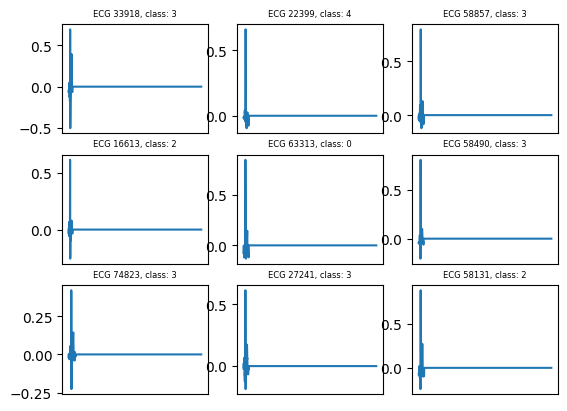

In [ ]:
# Muestra 9 señales aleatorias con sus clases
subplot_ecg(
    ecg_data=X_train_raw,      # shape (N,2048,1)
    labels=y_train,            # shape (N,)
    num_to_plot=9,
    lead=0
)
plt.show()

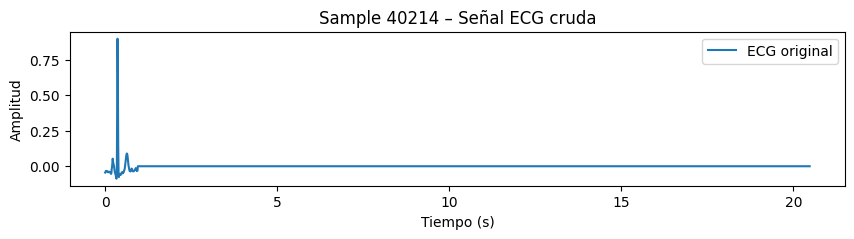

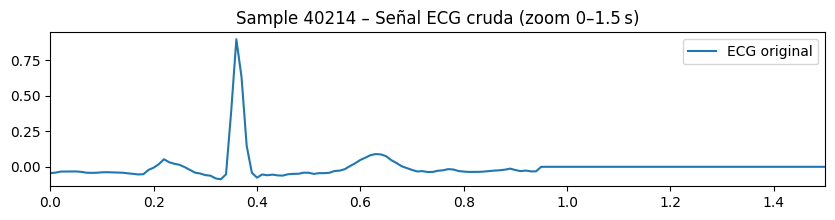

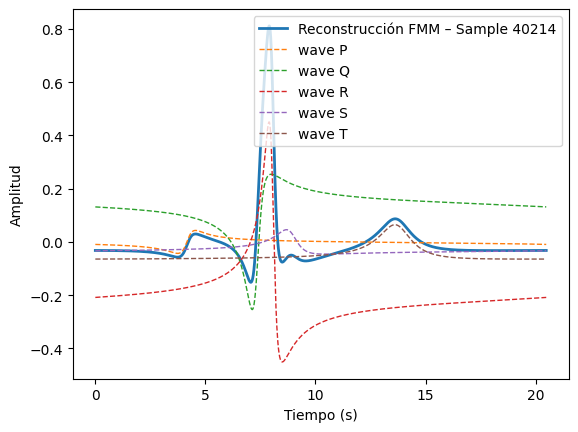

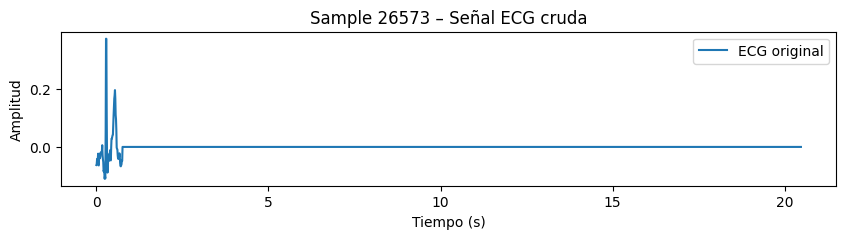

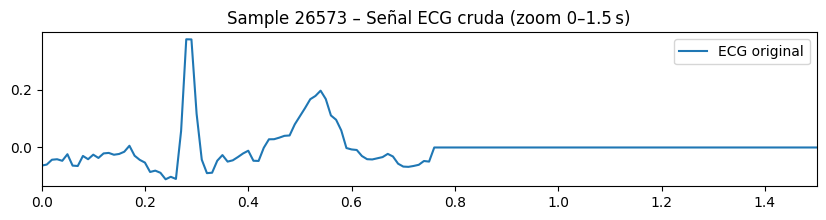

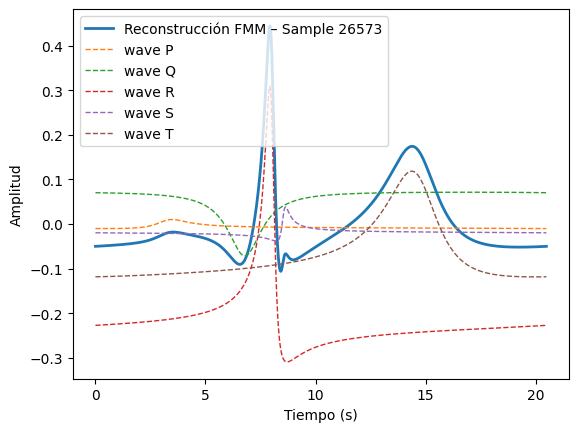

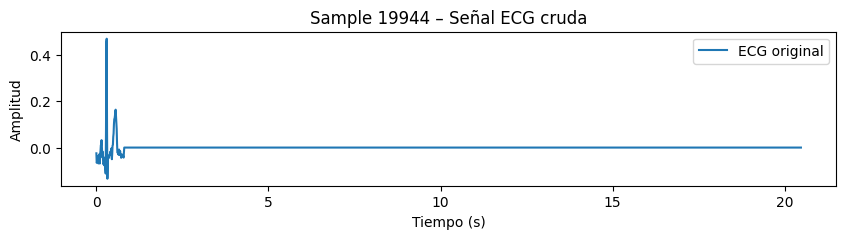

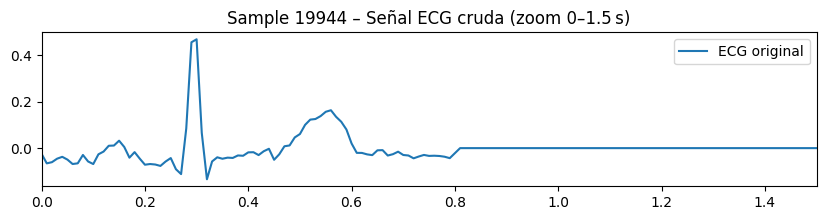

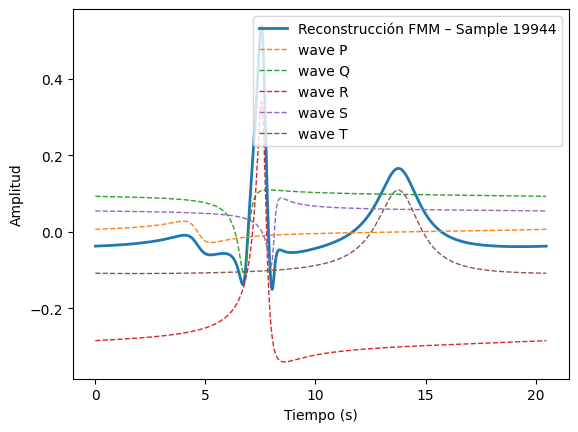

In [10]:
# Parámetros 
fs = 100
seq_len = 2048
num_leads = 1

# Elige unos índices al azar o fijos
np.random.seed(0)
indices = np.random.choice(len(X_train_raw), size=3, replace=False)


for idx in indices:
    ecg = X_train_raw[idx, :, 0]    # (2048,)
    coeff = coeffs_train[idx]       # (num_coefs,)

    # --- 1) Plot ECG original ---
    plt.figure(figsize=(10, 2)) 
    t = np.arange(seq_len) / fs
    plt.plot(t, ecg, label="ECG original")
    plt.title(f"Sample {idx} – Señal ECG cruda")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10,2))
    t = np.arange(seq_len) / fs 
    plt.plot(t, ecg, label="ECG original")
    plt.xlim(0, 1.5)       # muestra solo hasta 1.5 s
    plt.title(f"Sample {idx} – Señal ECG cruda (zoom 0–1.5 s)")
    plt.legend()
    plt.show()

    # --- 2) Plot FMM reconstruction ---
    # Convertir array a dict y generar curvas de onda
    fmm_dict = convert_fmm_array_to_dict( 
        fmm_array=coeff,
        num_leads=num_leads,
        num_waves=5
    )
    # Dibuja la suma de ondas + ondas individuales
    plot_fmm_wave_from_dict(
        fmm_coeff_dict=fmm_dict,
        seq_len=seq_len,
        fs=fs,
        lead=0,
        label=f"Reconstrucción FMM – Sample {idx}"
    )
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.show()

In [11]:
import numpy as np

print("ECG signal range:",
      X_train_raw.min(), X_train_raw.max(),
      " NaNs:", np.isnan(X_train_raw).sum(), 
      " Infs:", np.isinf(X_train_raw).sum())

print("FMM coeffs range:",
      coeffs_train.min(), coeffs_train.max(),
      " NaNs:", np.isnan(coeffs_train).sum(), 
      " Infs:", np.isinf(coeffs_train).sum())


ECG signal range: -1.608908478989276 2.520662652235402  NaNs: 0  Infs: 0
FMM coeffs range: -14936.216188791372 28248.38341346171  NaNs: 0  Infs: 0


In [12]:
# 1) Señal ECG: (N,2048,1)
mean_x = X_train_raw.mean()
std_x  = X_train_raw.std()
X_train_raw = (X_train_raw - mean_x) / (std_x + 1e-8)
X_test_raw  = (X_test_raw  - mean_x) / (std_x + 1e-8)

# 2) Coeficientes FMM: (N, C)
mean_c = coeffs_train.mean(axis=0)
std_c  = coeffs_train.std(axis=0)
coeffs_train = (coeffs_train - mean_c) / (std_c + 1e-8)
coeffs_test  = (coeffs_test  - mean_c) / (std_c + 1e-8)

In [13]:
from dataset import ECGWithFMM

In [14]:

# --- Create Multi-Channel Input ---
# The VAE will be trained on the signal (1 channel) + its FMM features (55 channels).
# We reshape the 55 coefficients to match the signal's time dimension (2048).
# train_coeffs_reshaped = np.repeat(np.expand_dims(coeffs_train, axis=1), 2048, axis=1)
# test_coeffs_reshaped = np.repeat(np.expand_dims(coeffs_test, axis=1), 2048, axis=1)


from torch.utils.data import DataLoader

# 2.1) Filtrar solo los ejemplares “normales” para el VAE
normal_id    = data_dict["params"]["normal_class"]
mask_norm    = (y_train == normal_id)

ds_norm      = ECGWithFMM(X_train_raw[mask_norm], coeffs_train[mask_norm])
dev_loader   = DataLoader(ds_norm, batch_size=32, shuffle=True,  num_workers=0)




In [15]:
# 2.2) Parámetros del VAE
INPUT_CH   = 1 + coeffs_train.shape[1]   # 1 canal ECG + C_fmm
latent_dim = 32
n_blocks    = 3
lr          = 1e-4
epochs      = 50
beta        = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [16]:
# 2.3) Instanciar modelo y optimizador
model     = VAE1D(input_ch=INPUT_CH, latent_dim=latent_dim, n_blocks=n_blocks).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [17]:

print("Training VAE on normals…")
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0

    for x in dev_loader:
        x = x.to(device)

        # 2) Forward
        mu, logv = model.encode(x)
        # 3) Clamp del log‑var para que no explote la KL
        logv = logv.clamp(-10.0, 10.0)
        z    = model.reparameterize(mu, logv)
        rec  = model.decode(z)

        # 4) Cálculo de pérdidas
        recon_loss = nn.functional.mse_loss(rec, x)
        kl_loss    = (-0.5 * (1 + logv - mu.pow(2) - logv.exp()).sum()) / x.size(0)
        loss       = recon_loss + beta * kl_loss

        # 5) Backward + gradient clipping
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(dev_loader)
    print(f" → Epoch {epoch}, loss = {avg:.6f}")


Training VAE on normals…
 → Epoch 1, loss = 4.484231
 → Epoch 2, loss = 2.309805
 → Epoch 3, loss = 7.321426
 → Epoch 4, loss = 7.261762
 → Epoch 5, loss = 1.723204
 → Epoch 6, loss = 0.849748
 → Epoch 7, loss = 0.843491
 → Epoch 8, loss = 0.842502
 → Epoch 9, loss = 0.844211
 → Epoch 10, loss = 0.853408
 → Epoch 11, loss = 0.842759
 → Epoch 12, loss = 0.848569
 → Epoch 13, loss = 0.842049
 → Epoch 14, loss = 0.844393
 → Epoch 15, loss = 0.841799
 → Epoch 16, loss = 0.844553
 → Epoch 17, loss = 0.841697
 → Epoch 18, loss = 0.842963
 → Epoch 19, loss = 0.842542
 → Epoch 20, loss = 0.842157
 → Epoch 21, loss = 0.841589
 → Epoch 22, loss = 0.841329
 → Epoch 23, loss = 0.842336
 → Epoch 24, loss = 0.841985
 → Epoch 25, loss = 0.841731
 → Epoch 26, loss = 0.841433
 → Epoch 27, loss = 0.883679
 → Epoch 28, loss = 0.841406
 → Epoch 29, loss = 0.842747
 → Epoch 30, loss = 0.844046
 → Epoch 31, loss = 0.844252
 → Epoch 32, loss = 0.841339
 → Epoch 33, loss = 0.841401
 → Epoch 34, loss = 0.84125

In [18]:
from torch.utils.data import TensorDataset

# 4.1) TensorDataset combinando normales y anomalías
#    (aquí ya convertimos todo a tensores de golpe porque es pequeño)
ds_clf = []
labels = []
for split in ["train","test"]:
    Xr = data_dict[split]["data"]         # (N,2048,1)
    Cr = data_dict[split]["coefficients"] # (N, C_fmm)
    Yr = data_dict[split]["labels"]
    # transformar a (N, 1+C_fmm, 2048)
    D  = ECGWithFMM(Xr, Cr)
    for i in range(len(D)):
        ds_clf.append((D[i], Yr[i]))
ds_clf = TensorDataset(
    torch.stack([x for x,y in ds_clf]),
    torch.tensor([y for x,y in ds_clf])
)
loader_clf = DataLoader(ds_clf, batch_size=32, shuffle=False, num_workers=0)




In [28]:
# # 4.2) Extraemos scores (recon errors + mu)
# errs, zs = compute_scores(model, loader_clf, device, beta=beta)
# errs = np.nan_to_num(errs, nan=0.0, posinf=1e6, neginf=-1e6)
# zs   = np.nan_to_num(zs,   nan=0.0, posinf=1e6, neginf=-1e6)

# X_clf = np.hstack([errs.reshape(-1,1), zs])
# y_clf = loader_clf.dataset.tensors[1].numpy()

# # 4.3) Entrenar XGBoost
# from xgboost import XGBClassifier
# clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
# clf.fit(X_clf, y_clf)
# print("XGBoost entrenado.")

# 4.2) Extraemos scores (recon errors + mu)
errs, zs = compute_scores(model, loader_clf, device, beta=beta)
errs = np.nan_to_num(errs, nan=0.0, posinf=1e6, neginf=-1e6)
zs   = np.nan_to_num(zs,   nan=0.0, posinf=1e6, neginf=-1e6)

X_clf = np.hstack([errs.reshape(-1,1), zs])
y_clf = loader_clf.dataset.tensors[1].numpy()  # originalmente 0..C-1

# —> BINARIZAMOS etiquetas: normal_id → 0, resto → 1
normal_id = data_dict["params"]["normal_class"]
y_clf_bin = np.where(y_clf == normal_id, 0, 1)

# 4.3) Entrenar XGBoost con las etiquetas binarias
from xgboost import XGBClassifier
clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
clf.fit(X_clf, y_clf_bin)
print("XGBoost entrenado (binario).")


c:\ProgramData\anaconda3\envs\TP-final_ML\lib\site-packages\xgboost\training.py:183: UserWarning: [23:13:53] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost entrenado (binario).



--- Métricas finales en el conjunto de evaluación ---
   roc_auc: 0.8609
  accuracy: 0.7801
 precision: 0.8315
    recall: 0.6233
        f1: 0.7125


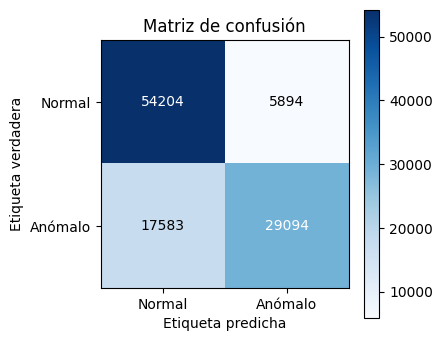

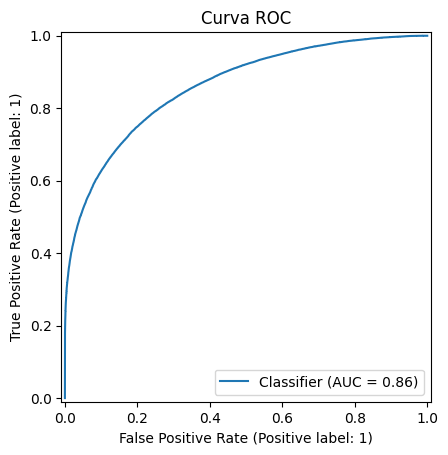

In [31]:
import numpy as np
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# — 1) Divide tu conjunto combinado en train/test si no lo hiciste —
# En tu caso loader_clf agrupa train+test. Si quieres usar solo test:
# Por ejemplo, suponiendo que conoces N_train:
# X_train_clf, y_train_clf = X_clf[:N_train], y_clf[:N_train]
# X_test_clf,  y_test_clf  = X_clf[N_train:], y_clf[N_train:]

# O si lo entrenaste con todo y no lo separaste:
# X_test_clf, y_test_clf = X_clf, y_clf
X_test_clf, y_test_clf = X_clf, y_clf_bin


# — 2) Obtén probabilidades y predicciones —
probs  = clf.predict_proba(X_test_clf)[:, 1]         # probabilidad de “anómalo”
y_pred = (probs >= 0.5).astype(int)                 # umbral en 0.5

# — 3) Calcula métricas —
metrics = {
    "roc_auc":   roc_auc_score(y_test_clf, probs),
    "accuracy":  accuracy_score(y_test_clf, y_pred),
    "precision": precision_score(y_test_clf, y_pred),
    "recall":    recall_score(y_test_clf, y_pred),
    "f1":        f1_score(y_test_clf, y_pred)
}
print("\n--- Métricas finales en el conjunto de evaluación ---")
for k,v in metrics.items():
    print(f"{k:>10s}: {v:.4f}")
    
    

# — 4) Matriz de confusión —
cm = confusion_matrix(y_test_clf, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.xticks([0,1], ["Normal","Anómalo"])
plt.yticks([0,1], ["Normal","Anómalo"])
for i in (0,1):
    for j in (0,1):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='white' if cm[i,j]>cm.max()/2 else 'black')
plt.ylabel("Etiqueta verdadera")
plt.xlabel("Etiqueta predicha")
plt.colorbar()
plt.show()

# — 5) Curva ROC —
RocCurveDisplay.from_predictions(y_test_clf, probs)
plt.title("Curva ROC")
plt.show()
